## **Dependencies and Libraries Install**

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow jiwer

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

## **Load Data**

In [ ]:
from google.colab import drive
import zipfile
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/LipReader/data.zip'
extract_path = '/content/'

In [ ]:
# Create the destination folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Display the list of files after extraction
os.listdir(extract_path)

['.config', 'data', 'drive', 'sample_data']

## **Create Vocab**

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['h','e','l','l','o'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 8,  5, 12, 12, 15])>

In [ ]:
num_to_char([ 8,  5, 12, 12, 15])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'h', b'e', b'l', b'l', b'o'], dtype=object)>

## **Create Data Loading Functions**

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
def load_alignments(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## **Test Data Loading**

In [ ]:
test_path = '/content/data/s1/bbaf3s.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf3s'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

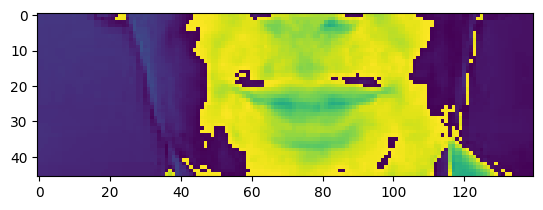

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20,  8, 18,
        5,  5, 39, 19, 15, 15, 14])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

## **Create Data Pipeline**

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
# train-test split
train = data.take(450)
test = data.skip(450)

## **Testing Data Pipeline**

In [ ]:
len(test),len(train)

(50, 450)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.4237285 ],
          [ 1.4237285 ],
          [ 1.4644064 ],
          ...,
          [ 0.        ],
          [ 0.08135591],
          [ 0.08135591]],

         [[ 1.4237285 ],
          [ 1.4237285 ],
          [ 1.4644064 ],
          ...,
          [ 0.        ],
          [ 0.08135591],
          [ 0.08135591]],

         [[ 1.3830504 ],
          [ 1.3830504 ],
          [ 1.3830504 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9762709 ],
          [ 0.9762709 ],
          [ 0.9762709 ],
          ...,
          [10.169489  ],
          [10.169489  ],
          [10.169489  ]],

         [[ 0.9762709 ],
          [ 0.9762709 ],
          [ 0.9762709 ],
          ...,
          [10.128811  ],
          [10.128811  ],
          [10.128811  ]],

         [[ 0.9762709 ],
          [ 0.9762709 ],
          [ 0.9762709 ],
          ...,
          [10.128811  ],
          [10.128811  ],
          

In [ ]:
val[0].shape

(2, 75, 46, 140, 1)

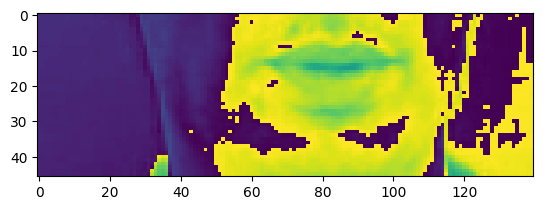

In [ ]:
# 0:videos, 0: 1st video out of the batch,  35: return the thirty-fifth frame in the video
plt.imshow(val[0][0][35])

In [ ]:
# 1:alignments 0:1st video of batch
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red by u seven soon'>

## **Design of Deep Neural Network**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

## **Setup Training Options and Train**

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
#model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

## **Make Prediction**

In [ ]:
checkpoints_source = "/content/drive/MyDrive/LipReader/model_checkpoints"
checkpoints_dest = "/content"

In [ ]:
!cp -r "$checkpoints_source" "$checkpoints_dest"

In [ ]:
model.load_weights('/content/model_checkpoints/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 9s 9s/step


In [ ]:
print("REAL TEXT :")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

REAL TEXT :


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white by v three soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print("PREDICTIONS :")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS :


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white by v three soon'>]

## **Test on a Video**

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbal8p.mpg'))

In [ ]:
print("REAL TEXT :")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

REAL TEXT :


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l eight please'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 781ms/step


In [ ]:
yhat

array([[[4.68622233e-07, 6.96361155e-07, 9.98931825e-01, ...,
         4.53856108e-09, 6.72427223e-06, 5.53322437e-08],
        [9.47112198e-07, 1.48825775e-05, 2.28150137e-04, ...,
         7.28212837e-11, 4.19916887e-06, 4.73503945e-07],
        [1.09269899e-06, 2.53867096e-04, 1.18353830e-06, ...,
         4.68897317e-12, 1.36283488e-05, 6.98059978e-07],
        ...,
        [9.99948978e-01, 4.71357509e-10, 1.11946175e-09, ...,
         4.97162381e-12, 7.48272999e-09, 5.07414843e-05],
        [8.04410447e-05, 5.20044618e-10, 4.93652841e-10, ...,
         1.56302282e-12, 2.78515566e-09, 9.99919057e-01],
        [9.99859214e-01, 3.15854587e-09, 7.37218864e-09, ...,
         1.05876308e-10, 7.26764924e-08, 1.39513184e-04]]], dtype=float32)

In [ ]:
yhat.shape

(1, 75, 41)

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print("PREDICTIONS :")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS :


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l eight please'>]

## **Results**

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
true_labels = []
predicted_sequences = []

# Assuming test_data is your iterator over the test dataset
for video_data in test_data:
    frames, true_labels_single_video = video_data
    true_labels_single_video = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in true_labels_single_video]

    # Assuming frames is the input to your model
    yhat_single_video = model.predict(frames)

    # Get the length of the sequence for each sample in the batch
    sequence_length = [yhat_single_video.shape[1]] * yhat_single_video.shape[0]

    # Perform CTC decoding
    decoded = tf.keras.backend.ctc_decode(yhat_single_video, input_length=sequence_length, greedy=True)[0][0].numpy()
    # Iterate over the videos in the batch
    for i in range(len(decoded)):
        decoded_strings_video = [num_to_char(word) for word in decoded[i]]
        predicted_video = ''.join([str(decoded_string.numpy(), 'utf-8') for decoded_string in decoded_strings_video])
        predicted_sequences.append(predicted_video)

    true_labels.append(true_labels_single_video[0])
    true_labels.append(true_labels_single_video[1])

# Print or use the lists as needed
print(true_labels)
print(predicted_sequences)

1/1 [==============================] - 0s 200ms/step
['bin red in z six now', 'bin red by a zero please', 'place red at p five soon', 'lay white in y nine again', 'bin red in l nine soon', 'bin white by t seven soon', 'lay blue with r five again', 'place blue by i nine soon', 'bin white with a eight now', 'place red by d zero now', 'bin red by m six now', 'lay blue by k five soon', 'bin blue in z three again', 'lay red with f one soon', 'bin red with n zero now', 'lay red by y eight now', 'lay white at z one soon', 'place blue by v nine again', 'bin blue by s five soon', 'place blue at c one soon', 'lay white at r seven soon', 'lay red at r two please', 'bin white with u zero now', 'place red by q one again', 'set blue with h six now', 'set green with d one soon', 'bin blue with g two please', 'set green at p two please', 'lay green in z three soon', 'bin red at g one again', 'lay red with f three again', 'bin white in t one again', 'lay white by l six now', 'bin red by t two please', 

In [ ]:
len(true_labels)

100

In [ ]:
len(predicted_sequences)

100

In [ ]:
true_labels


['bin red in z six now',
 'bin red by a zero please',
 'place red at p five soon',
 'lay white in y nine again',
 'bin red in l nine soon',
 'bin white by t seven soon',
 'lay blue with r five again',
 'place blue by i nine soon',
 'bin white with a eight now',
 'place red by d zero now',
 'bin red by m six now',
 'lay blue by k five soon',
 'bin blue in z three again',
 'lay red with f one soon',
 'bin red with n zero now',
 'lay red by y eight now',
 'lay white at z one soon',
 'place blue by v nine again',
 'bin blue by s five soon',
 'place blue at c one soon',
 'lay white at r seven soon',
 'lay red at r two please',
 'bin white with u zero now',
 'place red by q one again',
 'set blue with h six now',
 'set green with d one soon',
 'bin blue with g two please',
 'set green at p two please',
 'lay green in z three soon',
 'bin red at g one again',
 'lay red with f three again',
 'bin white in t one again',
 'lay white by l six now',
 'bin red by t two please',
 'bin red by t three

In [ ]:
predicted_sequences


['bin red in z six now',
 'bin red by a zero please',
 'place red at p five soon',
 'lay white in y nine again',
 'bin red in l nine soon',
 'bin white by t seven soon',
 'lay blue with r five again',
 'place blue by i nine soon',
 'bin white with a eight now',
 'place red by d zero now',
 'bin red by m six now',
 'lay blue by k five soon',
 'bin blue in z three again',
 'lay red with one soon',
 'bin red with n zero now',
 'lay red by y eight now',
 'lay white at z one soon',
 'place blue by v nine again',
 'bin blue by s five soon',
 'place blue at c one soon',
 'lay white at r seven soon',
 'lay red at r two please',
 'bin white with u zero now',
 'place red by k one again',
 'set blue with h six now',
 'set green with one soon',
 'bin blue with g two please',
 'set green at p two please',
 'lay green in z three soon',
 'bin red at g one again',
 'lay red with three again',
 'bin white in t one again',
 'lay white by l six now',
 'bin red by t two please',
 'bin red by t three again

In [ ]:
from jiwer import wer, cer

# Calculate the WER for each pair of sentences and take the average
wer_list = [wer(true, pred) for true, pred in zip(true_labels, predicted_sequences)]
wer_mean = sum(wer_list) / len(wer_list)

# Calculate the CER for each pair of sentences and take the average
cer_list = [cer(true, pred) for true, pred in zip(true_labels, predicted_sequences)]
cer_mean = sum(cer_list) / len(cer_list)

# Print the results
print(f"Average WER: {wer_mean*100:.2f}%")
print(f"Average CER: {cer_mean*100:.2f}%")


Average WER: 1.48%
Average CER: 0.68%


## **Confusion Matrix**

In [ ]:
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

unique_phonemes = ['aa', 'y', 'w', 'v', 'uw', 'th', 't', 's', 'r', 'p', 'ow', 'n', 'm', 'l', 'k', 'jh', 'iy', 'ih', 'g', 'f', 'ey', 'eh', 'd', 'ch', 'b', 'ay', 'aw', 'ao', 'ah', 'ae', 'z']

def get_phonemes(word, unique_phonemes):
    # Convert the word to lowercase
    word = word.lower().strip()

    # Create a list to store the filtered phonemes
    filtered_phonemes = []

    # Get the phonemes from the CMU Pronouncing Dictionary
    try:
        pronunciations = cmudict.dict()[word]
        for pronunciation in pronunciations:
            # Iterate over the phonemes in the pronunciation
            for phoneme in pronunciation:
              if phoneme.lower() in unique_phonemes:
                filtered_phonemes.append(phoneme.lower())
    except KeyError:
        # Handle the case where the word is not found in the dictionary
        pass

    return filtered_phonemes

# Example usage:
phonemes_for_hello = get_phonemes("hello", unique_phonemes)
print(phonemes_for_hello)


[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


['l', 'l']


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example true and predicted data (as sentences)
true_sentences = true_labels  # Replace with your actual data
predicted_sentences = predicted_sequences  # Replace with your actual data

# Function to convert a sentence to a sequence of phonemes
def sentence_to_phonemes(sentence,unique_phonemes):
    phonemes=[]
    for word in sentence.split():
        try:
            for phoneme in get_phonemes(word, unique_phonemes):
                phonemes.append(phoneme)
        except KeyError:
            # Skip the word if it's not found in the CMU Pronouncing Dictionary
            pass
    return phonemes

# Convert true and predicted sentences to sequences of phonemes
true_phonemes = [[phoneme for phoneme in sentence_to_phonemes(sentence, unique_phonemes)] for sentence in true_sentences]
predicted_phonemes = [[phoneme for phoneme in sentence_to_phonemes(sentence, unique_phonemes)] for sentence in predicted_sentences]

In [ ]:
len(true_phonemes)

100

In [ ]:
len(predicted_phonemes)

100

In [ ]:
true_phonems_flat = []
predicted_phonems_flat = []

for i in range(len(true_phonemes)):
    for j in range(len(true_phonemes[i])):
        true_phonems_flat.append(true_phonemes[i][j])
        try:
            predicted_phonems_flat.append(predicted_phonemes[i][j])
        except:
            true_phonems_flat.pop()

In [ ]:
len(true_phonems_flat),len(predicted_phonems_flat)

(1284, 1284)

<ipython-input-80-48a75dbf0be9>:5: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


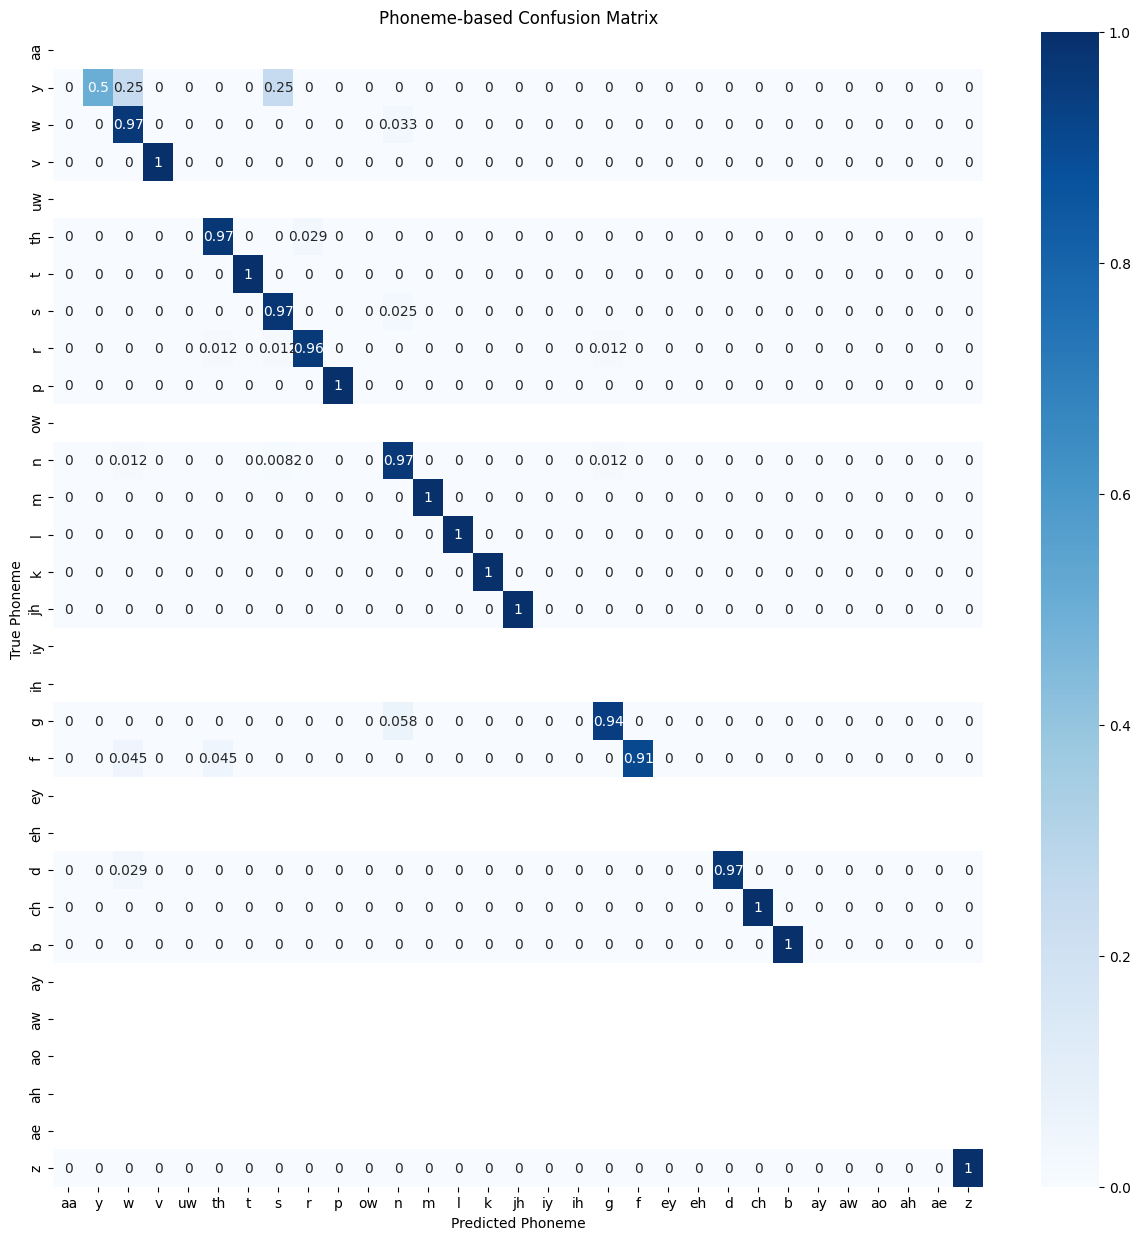

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_phonems_flat, predicted_phonems_flat, labels=unique_phonemes)

# Convert to percentage confusion matrix
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_percent, annot=True, cmap="Blues", xticklabels=unique_phonemes, yticklabels=unique_phonemes)
plt.title('Phoneme-based Confusion Matrix')
plt.xlabel('Predicted Phoneme')
plt.ylabel('True Phoneme')
plt.show()

## **Confusion Matrix 2**

In [ ]:
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

def get_phonemes(word):
    # Convert the word to lowercase
    word = word.lower().strip()

    # Create a list to store the filtered phonemes
    filtered_phonemes = []

    # Get the phonemes from the CMU Pronouncing Dictionary
    try:
        pronunciations = cmudict.dict()[word]
        for pronunciation in pronunciations:
            # Iterate over the phonemes in the pronunciation
            for phoneme in pronunciation:
                filtered_phonemes.append(phoneme.lower())
    except KeyError:
        # Handle the case where the word is not found in the dictionary
        pass

    return filtered_phonemes


# Example true and predicted data (as sentences)
true_sentences = true_labels  # Replace with your actual data
predicted_sentences = predicted_sequences  # Replace with your actual data

# Function to convert a sentence to a sequence of phonemes
def sentence_to_phonemes(sentence):
    phonemes=[]
    for word in sentence.split():
        try:
            for phoneme in get_phonemes(word):
                phonemes.append(phoneme)
        except KeyError:
            # Skip the word if it's not found in the CMU Pronouncing Dictionary
            pass
    return phonemes

# Convert true and predicted sentences to sequences of phonemes
true_phonemes = [[phoneme for phoneme in sentence_to_phonemes(sentence)] for sentence in true_sentences]
predicted_phonemes = [[phoneme for phoneme in sentence_to_phonemes(sentence)] for sentence in predicted_sentences]

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [ ]:
len(true_phonemes)

100

In [ ]:
true_phonems_flat = []
predicted_phonems_flat = []

for i in range(len(true_phonemes)):
    for j in range(len(true_phonemes[i])):
        true_phonems_flat.append(true_phonemes[i][j])
        try:
            predicted_phonems_flat.append(predicted_phonemes[i][j])
        except:
            true_phonems_flat.pop()

In [ ]:
unique_phonemes = sorted(set(true_phonems_flat))

In [ ]:
unique_phonemes

['aa1',
 'ae1',
 'ah0',
 'ah1',
 'ao1',
 'aw1',
 'ay1',
 'b',
 'ch',
 'd',
 'dh',
 'eh1',
 'ey1',
 'f',
 'g',
 'hh',
 'ih0',
 'ih1',
 'iy1',
 'jh',
 'k',
 'l',
 'm',
 'n',
 'ow0',
 'p',
 'r',
 's',
 't',
 'th',
 'uw1',
 'v',
 'w',
 'y',
 'z']

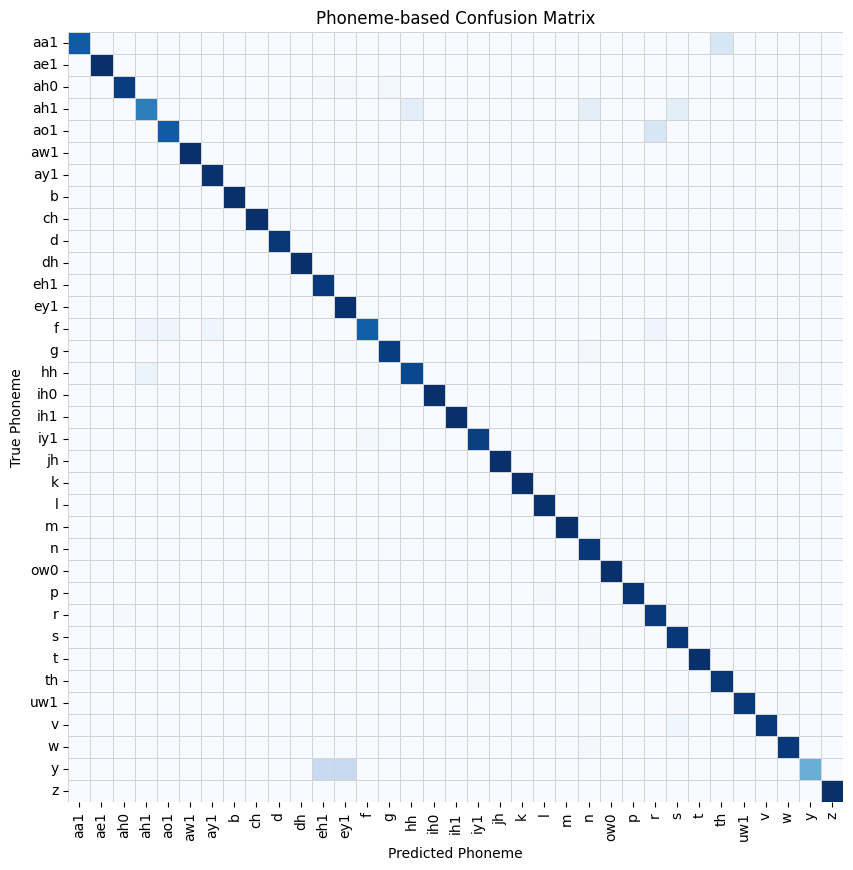

In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(true_phonems_flat, predicted_phonems_flat, labels=unique_phonemes)

# Convert to percentage confusion matrix
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with borders
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_percent, annot=False, cmap="Blues", xticklabels=unique_phonemes, yticklabels=unique_phonemes, cbar=False,
            linewidths=0.5, linecolor='lightgray')  # Adjust linewidths and linecolor for better visibility
plt.title('Phoneme-based Confusion Matrix')
plt.xlabel('Predicted Phoneme')
plt.ylabel('True Phoneme')

# Save the confusion matrix as a PDF file
plt.savefig('confusion_matrix.pdf', format='pdf')

plt.show()

## **Other**